In [1]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("Plotting geofeatures")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/04 13:32:38 WARN Utils: Your hostname, LAPTOP-VAB0S7AL resolves to a loopback address: 127.0.1.1; using 172.30.194.78 instead (on interface eth0)
22/10/04 13:32:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/10/04 13:32:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/04 13:32:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/04 13:32:40 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
import geopandas as gpd

In [3]:
# load postcode shapefile
sf = gpd.read_file("../../../data/tables/external_datasets/postcode_data/POA_2021_AUST_GDA94.shp")

In [4]:
sf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   POA_CODE21  2644 non-null   object  
 1   POA_NAME21  2644 non-null   object  
 2   AUS_CODE21  2644 non-null   object  
 3   AUS_NAME21  2644 non-null   object  
 4   AREASQKM21  2644 non-null   float64 
 5   LOCI_URI21  2644 non-null   object  
 6   SHAPE_Leng  2644 non-null   float64 
 7   SHAPE_Area  2644 non-null   float64 
 8   geometry    2641 non-null   geometry
dtypes: float64(3), geometry(1), object(5)
memory usage: 186.0+ KB


In [5]:
# what is ZZZZ? that's getting removed...
sf['POA_CODE21'].tail()

2639    7469
2640    7470
2641    9494
2642    9797
2643    ZZZZ
Name: POA_CODE21, dtype: object

In [6]:
import pandas as pd

In [7]:
# remove ZZZZ/non-numeric entry
sf = sf[pd.to_numeric(sf['POA_CODE21'], errors='coerce').notnull()]
sf.tail()

,POA_CODE21,POA_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,SHAPE_Leng,SHAPE_Area,geometry
2638,7468,7468,AUS,Australia,309.9494,http://linked.data.gov.au/dataset/asgsed3/POA/...,2.114872,0.033768,"MULTIPOLYGON (((145.39701 -42.13913, 145.39773..."
2639,7469,7469,AUS,Australia,5893.5125,http://linked.data.gov.au/dataset/asgsed3/POA/...,11.341556,0.636169,"MULTIPOLYGON (((144.79215 -41.46479, 144.79211..."
2640,7470,7470,AUS,Australia,108.2441,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.781048,0.011725,"POLYGON ((145.57768 -41.78641, 145.57686 -41.7..."
2641,9494,No usual address (Aust.),AUS,Australia,0.0000,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.000000,0.000000,None
2642,9797,Migratory - Offshore - Shipping (Aust.),AUS,Australia,0.0000,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.000000,0.000000,None


In [8]:
# cast shapefile postcode col to int (should be done in etl but just incase)
sf['POA_CODE21'] = sf['POA_CODE21'].astype('int')

In [9]:
#sf.head()

In [10]:
# get required subset from sdf
subset = ['postcode', 'dollar_value', 'mean_earnings_2018-19_avg', 'estimated_region_population_2021_sum']
sdf = spark.read.parquet("../../../data/curated/process_data.parquet/").select(subset)

In [11]:
# verify
sdf.printSchema()

root
 |-- postcode: integer (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- mean_earnings_2018-19_avg: double (nullable = true)
 |-- estimated_region_population_2021_sum: long (nullable = true)



In [12]:
# cast postcode to int to match the format of gdf (should be done in etl but just incase)
sdf = sdf.withColumn('postcode', sdf['postcode'].cast('int'))

In [13]:
sdf.printSchema()

root
 |-- postcode: integer (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- mean_earnings_2018-19_avg: double (nullable = true)
 |-- estimated_region_population_2021_sum: long (nullable = true)



In [14]:
# aggregate by postcode
postcode_dv = sdf \
                    .groupBy("postcode") \
                    .agg(F.sum("dollar_value").alias("sdvbypcode"),
                         F.mean("estimated_region_population_2021_sum").alias("avpopbypcode"),
                         F.mean('mean_earnings_2018-19_avg').alias('avearnbypcode')
                        ) \
                    .toPandas()

In [15]:
postcode_dv.info()
postcode_dv.describe()
postcode_dv.sort_values('postcode').head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3165 entries, 0 to 3164
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   postcode       3165 non-null   int32  
 1   sdvbypcode     3165 non-null   float64
 2   avpopbypcode   3160 non-null   float64
 3   avearnbypcode  3159 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 86.7 KB


,postcode,sdvbypcode,avpopbypcode,avearnbypcode
2496,200,353325.02,2161.0,19479.000000
1600,800,963580.89,7088.0,74682.000000
2478,801,749016.95,7088.0,74682.000000
102,804,587568.64,2827.0,88303.000000
1640,810,876106.04,35007.0,69868.833333


In [16]:
sf.info()
sf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2643 entries, 0 to 2642
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   POA_CODE21  2643 non-null   int64   
 1   POA_NAME21  2643 non-null   object  
 2   AUS_CODE21  2643 non-null   object  
 3   AUS_NAME21  2643 non-null   object  
 4   AREASQKM21  2643 non-null   float64 
 5   LOCI_URI21  2643 non-null   object  
 6   SHAPE_Leng  2643 non-null   float64 
 7   SHAPE_Area  2643 non-null   float64 
 8   geometry    2641 non-null   geometry
dtypes: float64(3), geometry(1), int64(1), object(4)
memory usage: 206.5+ KB


,POA_CODE21,POA_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,SHAPE_Leng,SHAPE_Area,geometry
0,800,0800,AUS,Australia,3.1731,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.081893,0.000264,"POLYGON ((130.83680 -12.45378, 130.83683 -12.4..."
1,810,0810,AUS,Australia,24.4283,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.241859,0.002031,"POLYGON ((130.89985 -12.36568, 130.89874 -12.3..."
2,812,0812,AUS,Australia,35.8899,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.278789,0.002983,"POLYGON ((130.91914 -12.40788, 130.91830 -12.4..."
3,820,0820,AUS,Australia,39.0642,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.409134,0.003248,"POLYGON ((130.85260 -12.43995, 130.85088 -12.4..."
4,822,0822,AUS,Australia,150775.8030,http://linked.data.gov.au/dataset/asgsed3/POA/...,90.601833,12.564239,"MULTIPOLYGON (((136.56647 -12.08393, 136.56703..."


In [17]:
# cast poa_code to int
sf['POA_CODE21'] = sf['POA_CODE21'].astype('int32')

In [18]:
# merge df's
postcode_join_sf = postcode_dv \
    .merge(sf[['POA_CODE21', 'geometry']], left_on='postcode', right_on='POA_CODE21') \
    .drop('POA_CODE21', axis=1)

In [19]:
postcode_join_sf.info()
#postcode_join_sf.sort_values('postcode')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2638 entries, 0 to 2637
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   postcode       2638 non-null   int32   
 1   sdvbypcode     2638 non-null   float64 
 2   avpopbypcode   2636 non-null   float64 
 3   avearnbypcode  2634 non-null   float64 
 4   geometry       2638 non-null   geometry
dtypes: float64(3), geometry(1), int32(1)
memory usage: 113.4 KB


<AxesSubplot:>

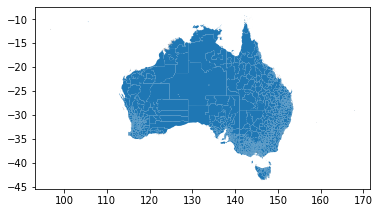

In [20]:
# inspect sf
sf.plot()

In [21]:
# convert to geopandas df
gdf = gpd.GeoDataFrame(postcode_join_sf)

In [22]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2638 entries, 0 to 2637
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   postcode       2638 non-null   int32   
 1   sdvbypcode     2638 non-null   float64 
 2   avpopbypcode   2636 non-null   float64 
 3   avearnbypcode  2634 non-null   float64 
 4   geometry       2638 non-null   geometry
dtypes: float64(3), geometry(1), int32(1)
memory usage: 113.4 KB


In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

Actual plots

In [57]:
def plot_feature(column, title):
    fig, ax = plt.subplots(1, figsize=(32,24), dpi=80)

    # make axis locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # plot
    gdf.plot(column=(column),
             legend=True,
             ax=ax,
             cax=cax,
             missing_kwds= dict(color = "red",),
             cmap='Blues_r',
             linewidth=0.05)
    ax = ax.set_title(title)
    ax = ax.set_size(25)


In [58]:
# cmaps: Blues_r, Blues, Reds_r, eh 

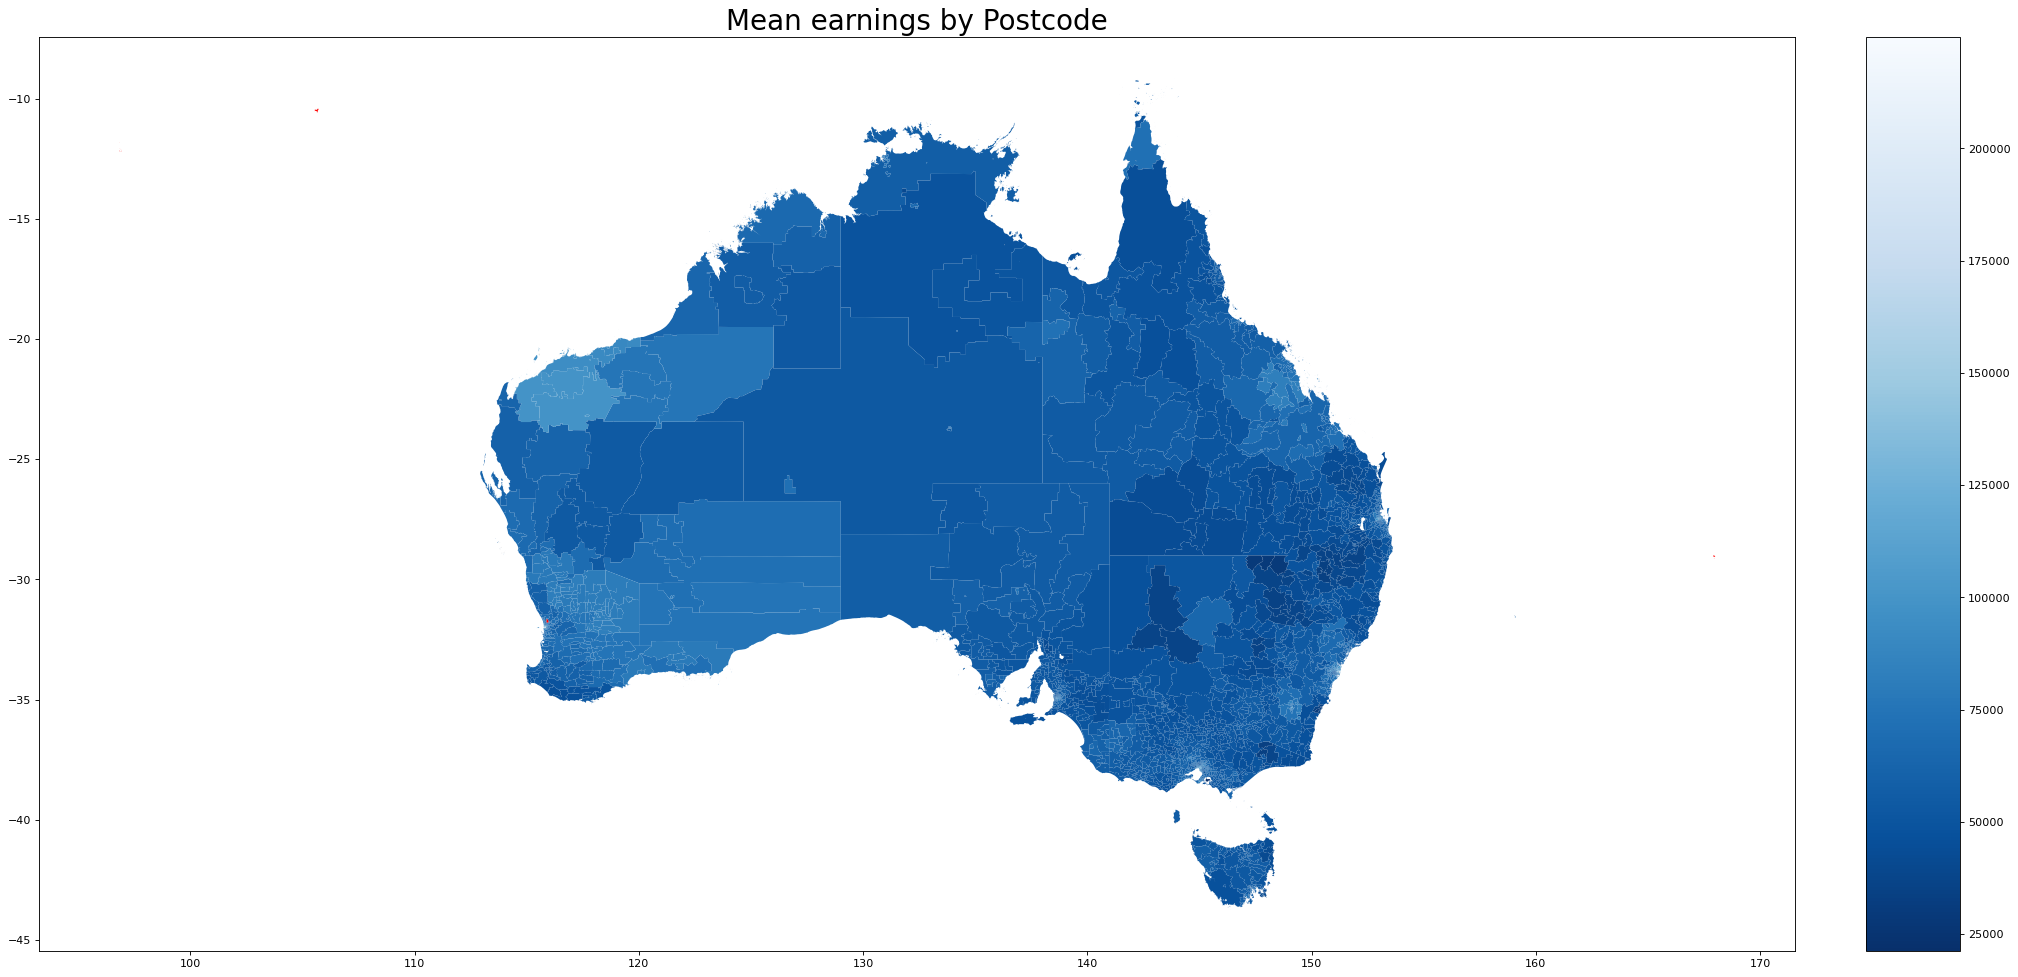

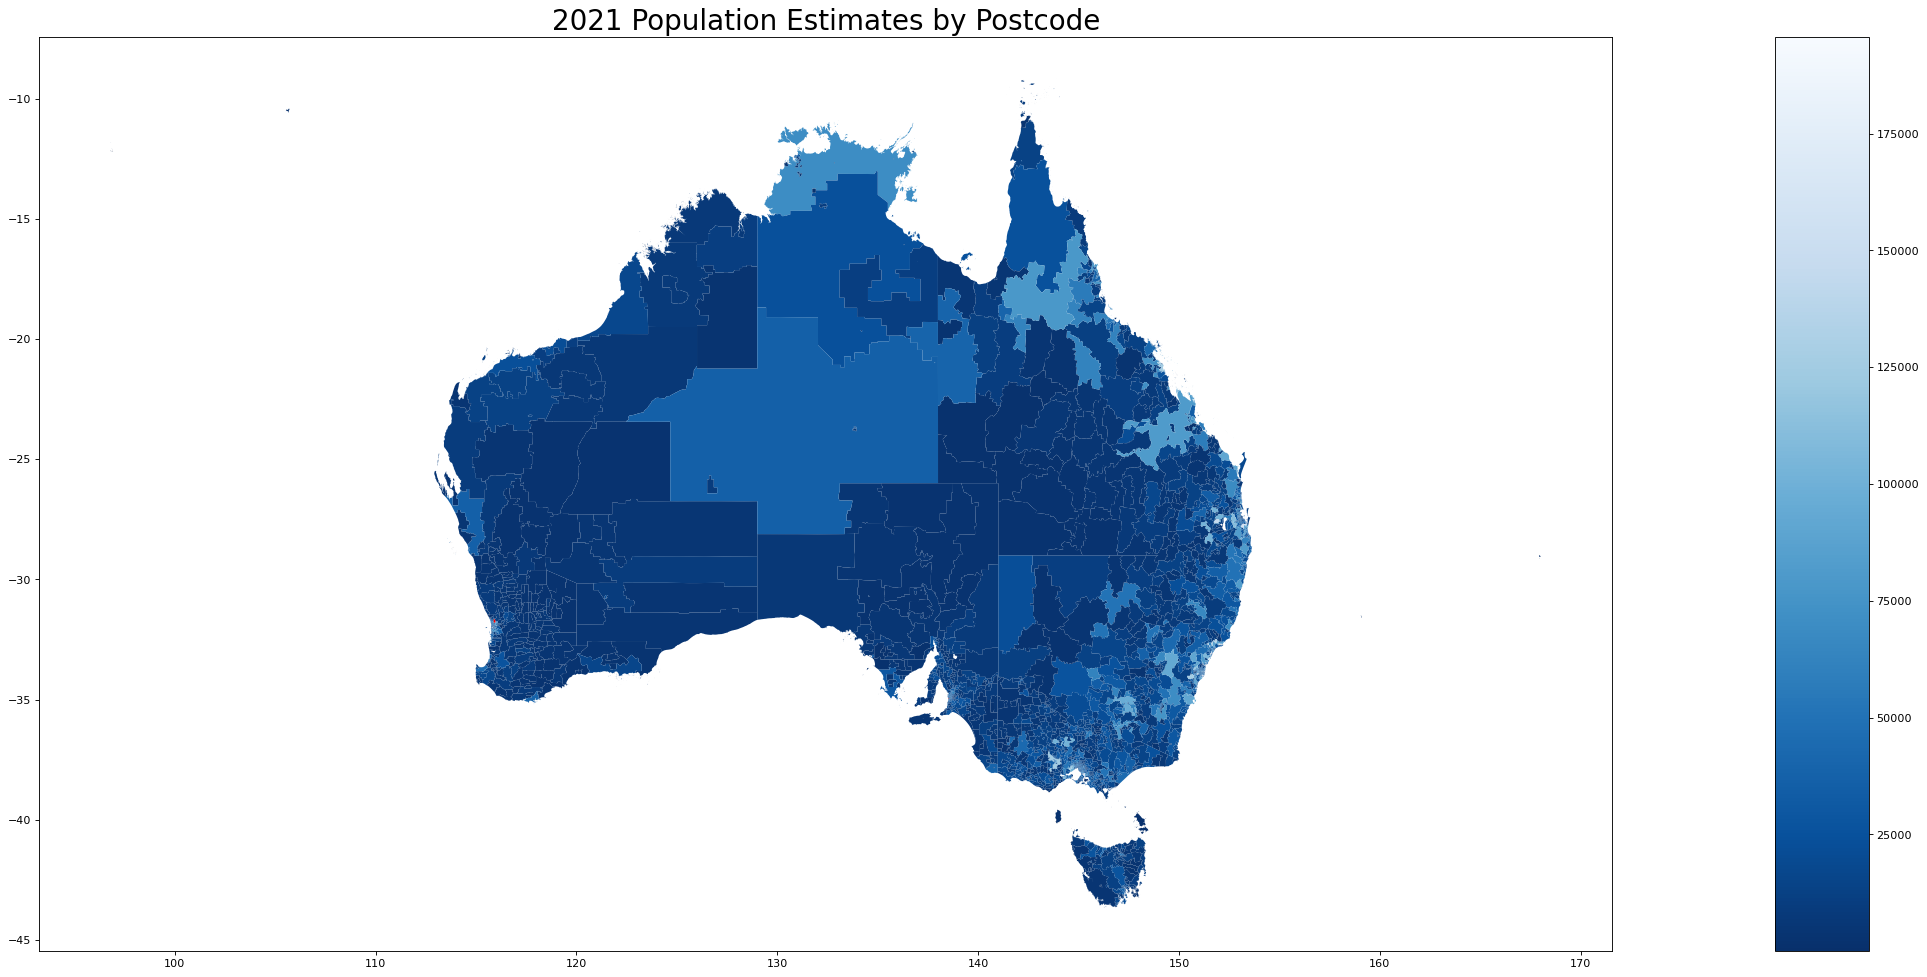

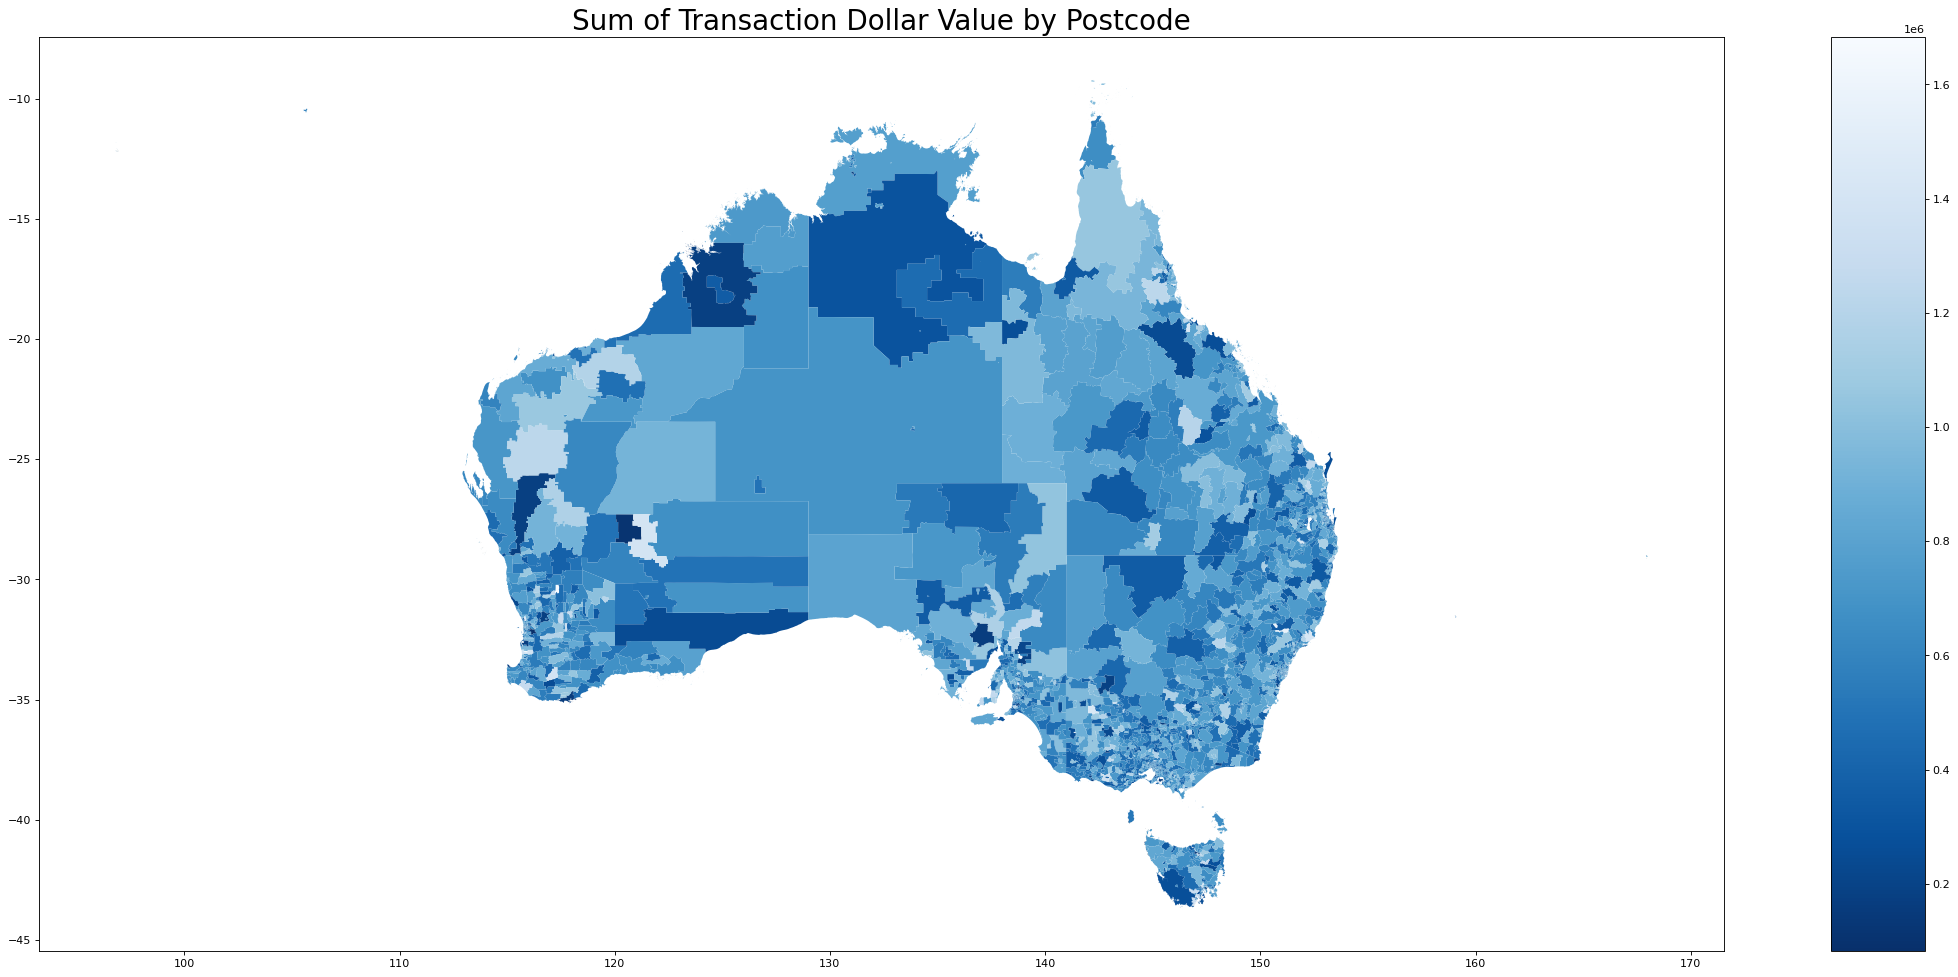

In [59]:
cols = {'avearnbypcode' : 'Mean annual earnings by Postcode',
        "avpopbypcode" : '2021 Population Estimates by Postcode',
        'sdvbypcode' : 'Sum of Transaction Dollar Values by Postcode'}

for col in cols:
    plot_feature(col, cols[col])